# Project 2: Deep Learning

###### Delanie Kidnie GDAA2010

This project will create a deep learning classification model to classify the number images in the MNIST dataset. 

#### Load Libraries

In [118]:
import os
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import os

device = torch.device("cpu")
device

device(type='cpu')

#### Load in MNIST dataset

In [119]:
# Define the directory where you want to save the dataset
download_path = 'C:\\Users\\delan\\Documents\\NSCC\\GDA1020\\datamining\\data\\MNIST'

# Check if the directory exists, if not create it
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Define the transformation
transform = transforms.ToTensor()

# Set the batch size
batch_size = 8

# Create the training dataset object
trainset = torchvision.datasets.MNIST(root=download_path, train=True, download=True, transform=transform)

# Create the test dataset object
testset = torchvision.datasets.MNIST(root=download_path, train=False, download=True, transform=transform)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Verify what the tensors look like and what the classes of the dataset are. 

In [120]:
train_iter = iter(trainset)
image, label = next(train_iter)

print(image.shape, label)
print(trainset.class_to_idx)

classes = trainset.classes
print(classes)

torch.Size([1, 28, 28]) 5
{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


Based on this information, this dataset has 1 channel, which makes sense since they are black and white images. The images are also 28 by 28 in size, and the first example has a class label of five. 

#### Visualize Tensor

Using `matplotlib` the transformed imagery in the tensor can be visualized. This is useful to ensure that the imagery is being processed properly and that labels are being applied correctly. 

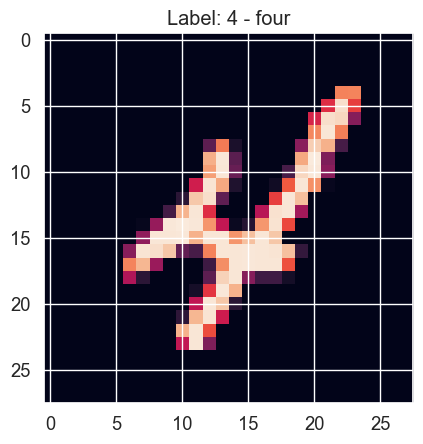

In [121]:
index = 9
image, label = trainset[index]

plt.imshow(image.permute(1,2,0))
plt.title(f'Label: {classes[label]}')
plt.show()

## Prepare Data for Training

Determine length of training and testing sets.

In [122]:
len(trainset), len(testset)

(60000, 10000)

Create subsets of training data for training and validation. For this project it was decided to separate a fifth of the training set into the validation dataset.

In [123]:
trainset, valset = torch.utils.data.random_split(trainset, [48000, 12000])

len(trainset), len(valset), len(testset)

(48000, 12000, 10000)

Check the number of batches data will be divided in for training and confirm that the training data is a subset of the overall dataset.

In [124]:
print(f'The number of batches in the training set {int(48000/batch_size)}')

print(f'The number of batches in the validation set {int(12000/batch_size)}')

print(type(trainset))

The number of batches in the training set 6000
The number of batches in the validation set 1500
<class 'torch.utils.data.dataset.Subset'>


## Model Preparation

#### Setup Data Loaders

While this model has been set up to run using CPU, it will still need data loaders to be established. The main difference being that the number of workers set for the data loaders will be zero, and there will be no use of the `pin_memory`.

In [125]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                          pin_memory=False)
valloader = torch.utils.data.DataLoader(valset, 
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=0,
                                          pin_memory=False)
testloader = torch.utils.data.DataLoader(testset, 
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=0,
                                          pin_memory=False)

## Convoluted Neural Network Architecture 

For this project the convoluted neural network model will be used as it is good for image classification.  This process involves creating a class to define the model. In the class there are four main components: convolution layers, max pooling layers, linear layers, and dropout layers. The convolution layers are there to idenfity key areas in the images like edges and textures, and with each increase in channels more information is aggregated from the images. The max pooling does essentially the opposite of teh convolution layers and downsample the data, and the purpose of this is to reduce model complexity. These two steps result in emphasis in the key features of images which helps the model to learn patterns more efficiently. 

Next the forward function needs to be called in the class, this will provide instructions for how the model will flow from one layer to the next. This step will also define the activation functions which help the model create curves of best fit for the data.

In [126]:
class OptimizedNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Gllobal Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        #fully connected layer
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        # convolutional + batchnorm + activation + pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # global average pooling
        x = self.gap(x)
        x = torch.flatten(x, 1)

        # fully connected output
        x = self.fc(x)

        return x

#### Push model to Device and Verify Parameters.

This step is more important when running a model on GPU but it does not inhibit the model on CPU and therefore was still included. 

In [127]:
net = OptimizedNeuralNet()
net.to(device)

OptimizedNeuralNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [128]:
for i, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {net(inputs).shape}')
    print(labels)
    break

input shape: torch.Size([8, 1, 28, 28])
after network shape: torch.Size([8, 10])
tensor([8, 7, 6, 0, 9, 1, 5, 7])


In [129]:
num_params = 0
for x in net.parameters():
    num_params += len(torch.flatten(x))
print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 94,410


## Select Loss Function and Optimization Technique

For this project the `CrossEntropyLoss` function was used because of its suitability with multi-class classigication models. The loss function is important as it is the parameter that the model will work to reduce by adjusting hyperparameters. The learning rate for this model was decided as 0.0001 and will determine the aggressiveness in which the model works to correct itself. 

In [130]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.0001)
optimizer2 = optim.Adam(net.parameters(), lr=0.001)

Two learning rates were tested and used to train the model. The first was 0.0001 which resulted in an accuracy of approximately 98%, and the second was 0.001 which resulted in an accuracy of approximately 99%. With the improvement from the second learning rate and the accuracy already being so high, it was determined that the 0.001 value was sufficient. 

## Define and Run Training Loops

#### Setup Training Epoch

The training epoch will be used to do exactly as it sounds, train the model. It is key to have the mode in `net.train` to be set to true for this. 

In [131]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, data in enumerate(trainloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer2.zero_grad()

    outputs = net(inputs) 
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size

    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer2.step()

    if batch_index % 500 == 499: 
      avg_loss_across_batches = running_loss / 500
      avg_acc_across_batches = (running_accuracy / 500) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          avg_loss_across_batches,
                                                          avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0

    
  print()

#### Setup Validation Epoch

The validation epoch will be used to run the trained model on the validation dataset and evaluate the results. This is why the `net.train` is set to false. Using the data provided by this function can inform on how well the model is running outside of the training data.

In [132]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            outputs = net(inputs) # shape: [batch_size, 5]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(valloader)
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

## Train the Model

The model will be trained using 5 epochs of training and validation loops.This means that the model will do 5 passes through the entire training and validation datasets. This allowed the model to reach accuracy of approximately 99%.

In [133]:
num_epochs = 5

for epoch_index in range(num_epochs):
    print(f'epoch: {epoch_index +1}\n')

    train_one_epoch()
    validate_one_epoch()

print('Finished Training')

epoch: 1



Batch 500, Loss: 0.686, Accuracy: 84.7%
Batch 1000, Loss: 0.236, Accuracy: 94.0%
Batch 1500, Loss: 0.149, Accuracy: 96.5%
Batch 2000, Loss: 0.119, Accuracy: 96.8%
Batch 2500, Loss: 0.099, Accuracy: 97.3%
Batch 3000, Loss: 0.093, Accuracy: 97.5%
Batch 3500, Loss: 0.110, Accuracy: 96.8%
Batch 4000, Loss: 0.077, Accuracy: 97.9%
Batch 4500, Loss: 0.073, Accuracy: 97.9%
Batch 5000, Loss: 0.066, Accuracy: 98.2%
Batch 5500, Loss: 0.068, Accuracy: 98.0%
Batch 6000, Loss: 0.070, Accuracy: 98.1%

Val Loss: 0.055, Val Accuracy: 98.2%
***************************************************

epoch: 2

Batch 500, Loss: 0.059, Accuracy: 98.4%
Batch 1000, Loss: 0.046, Accuracy: 98.7%
Batch 1500, Loss: 0.058, Accuracy: 98.1%
Batch 2000, Loss: 0.056, Accuracy: 98.1%
Batch 2500, Loss: 0.051, Accuracy: 98.4%
Batch 3000, Loss: 0.044, Accuracy: 98.6%
Batch 3500, Loss: 0.054, Accuracy: 98.4%
Batch 4000, Loss: 0.049, Accuracy: 98.7%
Batch 4500, Loss: 0.042, Accuracy: 98.7%
Batch 5000, Loss: 0.052, Accuracy: 98.2%

## Evaluate the Model

Now to see how well the model performs it will be tested on the test dataset created at the beginning. Evaluating the model involves calculating the accuracy of predictions, as well as considering the true/false positive and negative rates. The accuracy was calculating using the `accuracy_score` function and the positives and negatives were illustrated using a confusion matrix.

In [134]:
predicted_labels = []
true_labels = []

for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, dim=1)
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())


accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

class_report = classification_report(true_labels, predicted_labels, target_names=classes)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

Accuracy: 0.9906


Acuracy with learning rate of 0.0001: 0.9885

In [135]:
print("classification report", class_report)
print("confusion matrix: ", conf_matrix)

classification report               precision    recall  f1-score   support

    0 - zero       0.99      1.00      0.99       980
     1 - one       0.99      1.00      1.00      1135
     2 - two       0.98      0.99      0.99      1032
   3 - three       1.00      0.98      0.99      1010
    4 - four       0.98      1.00      0.99       982
    5 - five       0.99      0.99      0.99       892
     6 - six       1.00      0.99      0.99       958
   7 - seven       0.99      0.99      0.99      1028
   8 - eight       0.99      0.99      0.99       974
    9 - nine       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

confusion matrix:  [[ 977    0    1    0    0    0    1    1    0    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   1    2 1022    0    0    0    0    7    0    0]
 [   1    0   10  987    0    5    0    1

The classification report shows that the model had strong accuracy scores and evaluation scores for all classes. 

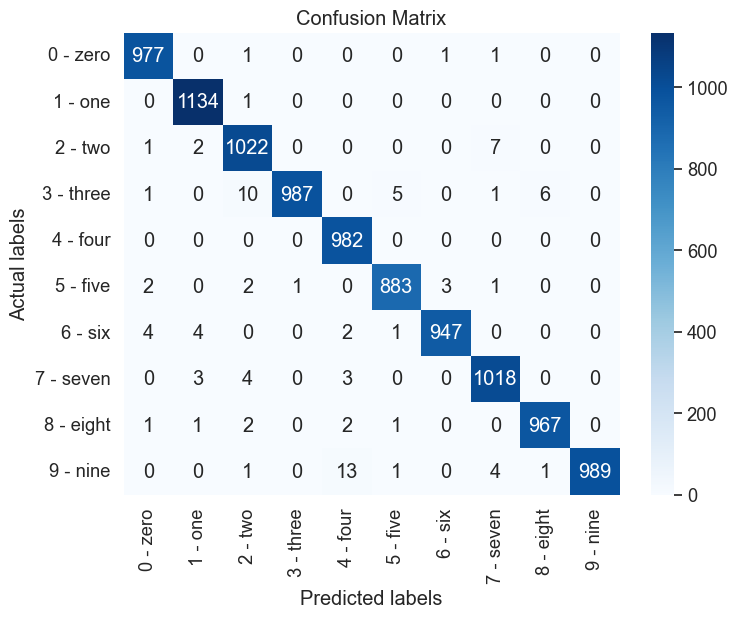

In [136]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Confusion Matrix")
plt.show()

Overall, the amount of misclassifications in the model were relatively low which aligns with the high accuracy score. There doesn't seem to be any value which is consistently the worst for getting misclassified, but the number 1 is by far the most accurate. 

## Save the Trained Model

To avoid having to retrain the model it is helpful to save the model to file.

In [137]:
save_dir = 'C:\\Users\\delan\\Documents\\NSCC\\GDA1020\\datamining\\models'

model_name = "MNIST_epoch.pth"
save_path = os.path.join(save_dir, model_name)

torch.save(net.state_dict(), save_path)

print(f"Model saved at:{save_path}")

Model saved at:C:\Users\delan\Documents\NSCC\GDA1020\datamining\models\MNIST_epoch.pth
